In [ ]:
#Python code for SVM and PCA for FPKM data set
#all cSTAR method calculations have been removed as data is sensitive

In [ ]:
import pandas as pd
import numpy as np
from numpy import NaN
from scipy import stats
import statistics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import linalg
from sklearn.decomposition import FastICA, PCA
from mpl_toolkits.mplot3d import Axes3D

# the following lines must be uncommented if you want to have interactive plots
%matplotlib inline  
%matplotlib notebook
%pylab

In [158]:
# reading WT vs mutant dataset
WTvsMUT = pd.read_csv('RNA_seq_TNF_full_new_Nov2018.txt',sep='\t').set_index("external_gene_name")

# calculating fold changes with respect to control
AV_1h = WTvsMUT.filter(regex='1h.*NT.*').sum(axis=1)/len(WTvsMUT.filter(regex='1h.*NT.*').columns)
AV_B6 = WTvsMUT.filter(regex='B6.*NT.*').sum(axis=1)/len(WTvsMUT.filter(regex='B6.*NT.*').columns)



for cond in WTvsMUT.filter(regex='MK.*1h.*'):
    WTvsMUT[cond] = WTvsMUT[cond]/AV_1h

for cond in WTvsMUT.filter(regex='MK.*B6.*'):
    WTvsMUT[cond] = WTvsMUT[cond]/AV_B6

    
# filling NaNs which come from division by 0
WTvsMUT = WTvsMUT.fillna(1)
WTvsMUT = WTvsMUT.replace([np.inf, -np.inf], 1)

# deleting controls
for cond in WTvsMUT.filter(regex='NT'):
    del WTvsMUT[cond]

# data
WTvsMUT

,gene_id,MK16_1h_50ng_B_R1_FPKM,MK15_1h_10ng_B_R1_FPKM,MK14_1h_2ng_B_R1_FPKM,MK12_B6_50ng_B_R1_FPKM,MK11_B6_10ng_B_R1_FPKM,MK10_B6_2ng_B_R1_FPKM,MK8_1h_50ng_A_R1_FPKM,MK7_1h_10ng_A_R1_FPKM,MK6_1h_2ng_A_R1_FPKM,MK4_B6_50ng_A_R1_FPKM,MK3_B6_10ng_A_R1_FPKM,MK2_B6_2ng_A_R1_FPKM
external_gene_name,,,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,0.770265,0.653717,1.037978,1.006843,0.629309,0.931956,0.804632,0.657950,0.969493,0.952615,0.697482,0.895029
Pbsn,ENSMUSG00000000003,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Cdc45,ENSMUSG00000000028,0.265455,0.802727,1.350909,0.227230,1.004695,1.562441,0.246364,0.824545,1.477273,0.253521,1.047887,1.898592
H19,ENSMUSG00000000031,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
Scml2,ENSMUSG00000000037,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,6.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm2165,ENSMUSG00000096911,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Gm24866,ENSMUSG00000096913,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Galntl6,ENSMUSG00000096914,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [159]:
#calculating log 2 of the fold changes
Log2WTvsMUT = WTvsMUT.apply(lambda x: np.log2(x) if np.issubdtype(x.dtype, np.number) else x)

Log2WTvsMUT

/Users/brianwood/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gene_id,MK16_1h_50ng_B_R1_FPKM,MK15_1h_10ng_B_R1_FPKM,MK14_1h_2ng_B_R1_FPKM,MK12_B6_50ng_B_R1_FPKM,MK11_B6_10ng_B_R1_FPKM,MK10_B6_2ng_B_R1_FPKM,MK8_1h_50ng_A_R1_FPKM,MK7_1h_10ng_A_R1_FPKM,MK6_1h_2ng_A_R1_FPKM,MK4_B6_50ng_A_R1_FPKM,MK3_B6_10ng_A_R1_FPKM,MK2_B6_2ng_A_R1_FPKM
external_gene_name,,,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,-0.376573,-0.613262,0.053776,0.009839,-0.668159,-0.101666,-0.313599,-0.603949,-0.044697,-0.070035,-0.519772,-0.159994
Pbsn,ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,ENSMUSG00000000028,-1.913463,-0.317018,0.433931,-2.137774,0.006757,0.643802,-2.021139,-0.278329,0.562936,-1.979822,0.067484,0.924930
H19,ENSMUSG00000000031,0.000000,0.000000,0.000000,-inf,-inf,-inf,0.000000,0.000000,0.000000,-inf,-inf,-inf
Scml2,ENSMUSG00000000037,-inf,-inf,-inf,0.000000,0.000000,0.000000,-inf,-inf,2.584963,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm2165,ENSMUSG00000096911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm24866,ENSMUSG00000096913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Galntl6,ENSMUSG00000096914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [160]:
# filling NaNs which come from division by 0 and remove infinite values
Log2WTvsMUT = Log2WTvsMUT.fillna(1)
Log2WTvsMUT = Log2WTvsMUT.replace([np.inf, -np.inf], 1)
Log2WTvsMUT = Log2WTvsMUT[(Log2WTvsMUT.T != 0).any()]
Log2WTvsMUT

,gene_id,MK16_1h_50ng_B_R1_FPKM,MK15_1h_10ng_B_R1_FPKM,MK14_1h_2ng_B_R1_FPKM,MK12_B6_50ng_B_R1_FPKM,MK11_B6_10ng_B_R1_FPKM,MK10_B6_2ng_B_R1_FPKM,MK8_1h_50ng_A_R1_FPKM,MK7_1h_10ng_A_R1_FPKM,MK6_1h_2ng_A_R1_FPKM,MK4_B6_50ng_A_R1_FPKM,MK3_B6_10ng_A_R1_FPKM,MK2_B6_2ng_A_R1_FPKM
external_gene_name,,,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,-0.376573,-0.613262,0.053776,0.009839,-0.668159,-0.101666,-0.313599,-0.603949,-0.044697,-0.070035,-0.519772,-0.159994
Pbsn,ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,ENSMUSG00000000028,-1.913463,-0.317018,0.433931,-2.137774,0.006757,0.643802,-2.021139,-0.278329,0.562936,-1.979822,0.067484,0.924930
H19,ENSMUSG00000000031,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
Scml2,ENSMUSG00000000037,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.584963,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm2165,ENSMUSG00000096911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm24866,ENSMUSG00000096913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Galntl6,ENSMUSG00000096914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [161]:
# running PCA
pca = PCA(n_components=3)
Spca = pca.fit_transform(Log2WTvsMUT.filter(regex='MK').transpose())
#PCAweights = pca.components_.transpose()
print("Explained variances by components: ", pca.explained_variance_ratio_, "total variance explained: ",sum(pca.explained_variance_ratio_))
PCA_WTvsMUT = pd.DataFrame(Spca,columns=['PC1','PC2','PC3'],index=Log2WTvsMUT.filter(regex='MK').columns)
PCA_WTvsMUT

Explained variances by components:  [0.37385683 0.23429374 0.09336629] total variance explained:  0.7015168515400516


,PC1,PC2,PC3
MK16_1h_50ng_B_R1_FPKM,-76.675964,-49.761301,-11.163990
MK15_1h_10ng_B_R1_FPKM,-8.601125,-52.871032,33.326708
MK14_1h_2ng_B_R1_FPKM,66.228075,-36.460305,-38.154068
MK12_B6_50ng_B_R1_FPKM,-73.979517,69.928074,-28.887295
MK11_B6_10ng_B_R1_FPKM,11.120661,39.839249,45.538465
MK10_B6_2ng_B_R1_FPKM,81.552951,30.634249,-6.172405
MK8_1h_50ng_A_R1_FPKM,-79.711473,-51.446013,-13.439589
MK7_1h_10ng_A_R1_FPKM,-9.981196,-55.216710,36.637418
MK6_1h_2ng_A_R1_FPKM,66.835369,-35.821875,-36.943713
MK4_B6_50ng_A_R1_FPKM,-71.160900,69.496452,-21.586939


<IPython.core.display.Javascript object>


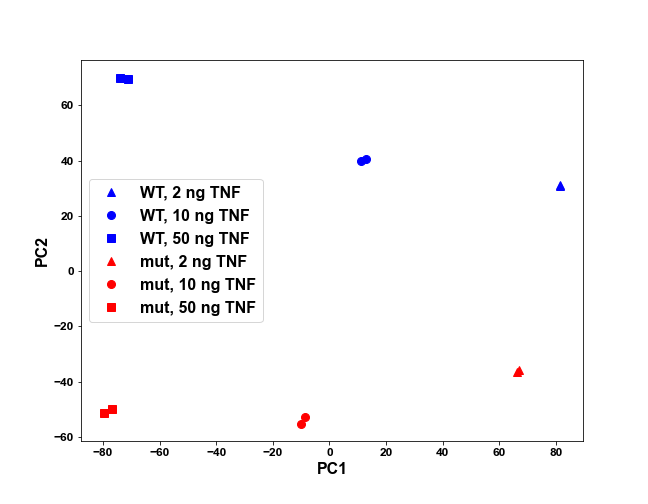

In [162]:
# plotting PCA

fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

ax.plot(PCA_WTvsMUT.filter(regex='B6_2ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='B6_2ng',axis=0).iloc[:,1],'^',color='blue',label='WT, 2 ng TNF',ms=8) 
ax.plot(PCA_WTvsMUT.filter(regex='B6_10ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='B6_10ng',axis=0).iloc[:,1],'o',color='blue',label='WT, 10 ng TNF',ms=8) 
ax.plot(PCA_WTvsMUT.filter(regex='B6_50ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='B6_50ng',axis=0).iloc[:,1],'s',color='blue',label='WT, 50 ng TNF',ms=8) 

ax.plot(PCA_WTvsMUT.filter(regex='1h_2ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='1h_2ng',axis=0).iloc[:,1],'^',color='red',label='mut, 2 ng TNF',ms=8) 
ax.plot(PCA_WTvsMUT.filter(regex='1h_10ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='1h_10ng',axis=0).iloc[:,1],'o',color='red',label='mut, 10 ng TNF',ms=8) 
ax.plot(PCA_WTvsMUT.filter(regex='1h_50ng',axis=0).iloc[:,0],PCA_WTvsMUT.filter(regex='1h_50ng',axis=0).iloc[:,1],'s',color='red',label='mut, 50 ng TNF',ms=8) 

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.legend(numpoints=1,prop=fontLabel)
plt.show()

# we can see clear separation

<IPython.core.display.Javascript object>


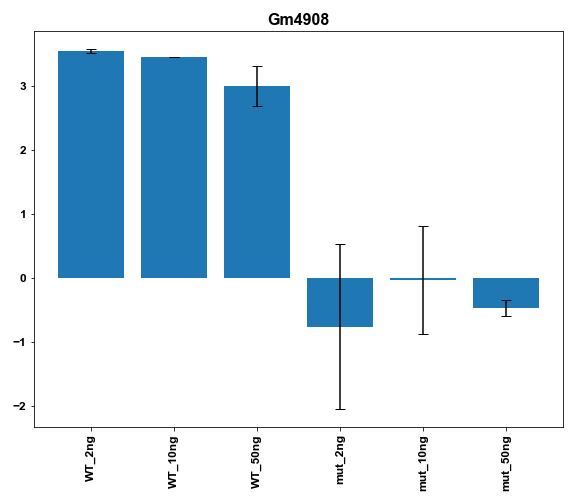

In [165]:
# making bar plot for specific gene
# a handy (IMHO) tool to quickly look for some specific data
gene_name = "Gm4908"

WT_2ng = Log2WTvsMUT.filter(regex='B6_2ng')
WT_10ng = Log2WTvsMUT.filter(regex='B6_10ng')
WT_50ng = Log2WTvsMUT.filter(regex='B6_50ng')

mut_2ng = Log2WTvsMUT.filter(regex='1h_2ng')
mut_10ng = Log2WTvsMUT.filter(regex='1h_10ng')
mut_50ng = Log2WTvsMUT.filter(regex='1h_50ng')

WT_2ng_gene = statistics.mean(WT_2ng.loc[gene_name])
WT_2ng_err = stats.sem(WT_2ng.loc[gene_name])
WT_10ng_gene = statistics.mean(WT_10ng.loc[gene_name])
WT_10ng_err = stats.sem(WT_10ng.loc[gene_name])
WT_50ng_gene = statistics.mean(WT_50ng.loc[gene_name])
WT_50ng_err = stats.sem(WT_50ng.loc[gene_name])

mut_2ng_gene = statistics.mean(mut_2ng.loc[gene_name])
mut_2ng_err = stats.sem(mut_2ng.loc[gene_name])
mut_10ng_gene = statistics.mean(mut_10ng.loc[gene_name])
mut_10ng_err = stats.sem(mut_10ng.loc[gene_name])
mut_50ng_gene = statistics.mean(mut_50ng.loc[gene_name])
mut_50ng_err = stats.sem(mut_50ng.loc[gene_name])


names = ['WT_2ng','WT_10ng','WT_50ng','mut_2ng','mut_10ng','mut_50ng']
values = [WT_2ng_gene,WT_10ng_gene,WT_50ng_gene,mut_2ng_gene,mut_10ng_gene,mut_50ng_gene]
errs = [WT_2ng_err,WT_10ng_err,WT_50ng_err,mut_2ng_err,mut_10ng_err,mut_50ng_err]

fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.title(gene_name,**fontTitle)
plt.bar(names,values,yerr=errs,capsize=5)
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

In [168]:
# read perturbations dataset
pert_ds = pd.read_csv('fpkm_genename.xls',sep='\t').set_index("gene_name")

# calculating fold changes with respect to control
AV_1h_pert = pert_ds.filter(regex='UNTREAT').sum(axis=1)/len(pert_ds.filter(regex='UNTREAT').columns)
for cond in pert_ds.filter(regex='\d'):
    pert_ds[cond] = pert_ds[cond]/AV_1h_pert

# filling NaNs which come from division by 0
pert_ds = pert_ds.fillna(1)
pert_ds = pert_ds.replace([np.inf, -np.inf], 1)

# deleting controls
for cond in pert_ds.filter(regex='UNTREAT'):
    del pert_ds[cond]

# data 
pert_dat = pert_ds.filter(regex='\d')
pert_dat

,T_1,T_2,T_3,M_1,M_2,M_3,TM_1,TM_2,TM_3,TMR_1,...,TMS_3,TMH_1,TMH_2,TMH_3,TMRS_1,TMRS_2,TMRS_3,TMRH_1,TMRH_2,TMRH_3
gene_name,,,,,,,,,,,,,,,,,,,,,
Gm23935,0.899277,1.381436,0.686430,0.793316,0.927538,0.784907,1.622286,0.767964,1.783458,1.385224,...,1.601612,2.378616,0.687550,1.746071,1.736425,1.266103,1.545688,1.294067,2.147054,1.761152
Fth1,1.434870,1.460243,1.340475,1.066263,1.183164,1.111666,1.382624,1.847273,1.376060,0.652503,...,1.215603,1.845769,1.284359,1.422825,0.686755,0.628233,0.616864,0.648673,0.623016,0.635610
Lyz2,0.935660,0.962648,0.930209,0.924287,0.879215,0.939558,0.915902,1.172356,0.870558,0.472471,...,0.773404,0.689685,0.695731,0.830241,0.582275,0.470577,0.469330,0.520035,0.536220,0.523278
Psap,0.988090,1.003618,0.932042,0.911238,0.922216,0.932077,0.913151,1.314444,0.926806,0.527585,...,0.890213,0.907963,0.812496,0.961471,0.575193,0.538201,0.536643,0.526864,0.514692,0.510236
mt-Co1,0.939296,0.964534,0.928237,0.828665,0.929276,0.830601,0.898177,0.417827,0.881637,0.735258,...,1.017936,1.248285,1.320129,1.005939,0.725742,0.752703,0.676352,0.787811,0.687843,0.758797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CR524822.1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
CAAA01205117.2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
CAAA01205117.1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
#calculating log 2 of the fold changes for perturbation data
Log2pert_ds = pert_dat.apply(lambda x: np.log2(x) if np.issubdtype(x.dtype, np.number) else x)

# filling NaNs which come from division by 0 and remove infinite values
Log2pert_ds = Log2pert_ds.fillna(1)
Log2pert_ds = Log2pert_ds.replace([np.inf, -np.inf], 1)
Log2pert_ds = Log2pert_ds[(Log2pert_ds.T != 0).any()]
Log2pert_ds


Log2pert_ds

/Users/brianwood/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,T_1,T_2,T_3,M_1,M_2,M_3,TM_1,TM_2,TM_3,TMR_1,...,TMS_3,TMH_1,TMH_2,TMH_3,TMRS_1,TMRS_2,TMRS_3,TMRH_1,TMRH_2,TMRH_3
gene_name,,,,,,,,,,,,,,,,,,,,,
Gm23935,-0.153163,0.466169,-0.542816,-0.334032,-0.108522,-0.349407,0.698028,-0.380889,0.834678,0.470119,...,0.679525,1.250123,-0.540464,0.804112,0.796120,0.340395,0.628249,0.371912,1.102358,0.816519
Fth1,0.520920,0.546208,0.422744,0.092563,0.242650,0.152724,0.467409,0.885397,0.460543,-0.615944,...,0.281672,0.884222,0.361049,0.508759,-0.542133,-0.670628,-0.696976,-0.624438,-0.682659,-0.653786
Lyz2,-0.095944,-0.054920,-0.104373,-0.113587,-0.185712,-0.089947,-0.126735,0.229410,-0.199988,-1.081701,...,-0.370706,-0.535990,-0.523398,-0.268398,-0.780228,-1.087497,-1.091327,-0.943320,-0.899102,-0.934349
Psap,-0.017285,0.005210,-0.101533,-0.134101,-0.116824,-0.101478,-0.131075,0.394453,-0.109660,-0.922525,...,-0.167778,-0.139295,-0.299567,-0.056684,-0.797881,-0.893782,-0.897965,-0.924498,-0.958218,-0.970762
mt-Co1,-0.090349,-0.052096,-0.107435,-0.271140,-0.105821,-0.267773,-0.154928,-1.259022,-0.181744,-0.443678,...,0.025646,0.319948,0.400679,0.008542,-0.462472,-0.409847,-0.564153,-0.344078,-0.539849,-0.398214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Frem2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Olfr1238,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Duox2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
# running PCA
pca = PCA(n_components=3)
Spca = pca.fit_transform(Log2pert_ds.filter(regex='\d').transpose())
#PCAweights = pca.components_.transpose()
print("Explained variances by components: ", pca.explained_variance_ratio_, "total variance explained: ",sum(pca.explained_variance_ratio_))
PCA_pert = pd.DataFrame(Spca,columns=['PC1','PC2','PC3'],index=pert_ds.filter(regex='\d').columns)
PCA_pert

Explained variances by components:  [0.27136899 0.05601615 0.05023616] total variance explained:  0.37762129714919357


,PC1,PC2,PC3
T_1,-55.460010,5.407540,-3.109075
T_2,-51.030357,8.308579,-11.079924
T_3,-55.490767,3.174520,-4.525424
M_1,-53.513389,47.014410,-27.728658
M_2,-53.785314,41.319453,-31.766636
M_3,-58.980640,44.563617,-29.695539
TM_1,-52.816119,2.717181,-5.801740
TM_2,-56.117026,48.738524,113.098133
TM_3,-51.897917,0.729109,-3.203427
TMR_1,52.721827,11.927418,-9.390773


<IPython.core.display.Javascript object>


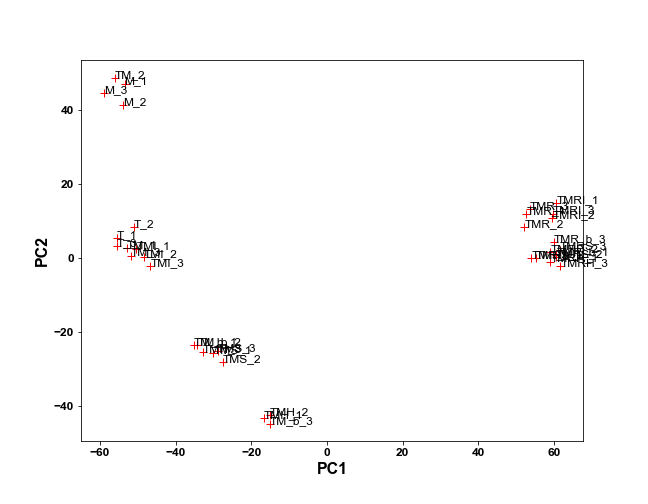

In [172]:
# plotting PCA

fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

ax.plot(PCA_pert.iloc[:,0],PCA_pert.iloc[:,1],'+',color='red',ms=8) 

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

for smpl in PCA_pert.index:
    ax.annotate(smpl,(PCA_pert.loc[smpl][0],PCA_pert.loc[smpl][1]))

#ax.legend(numpoints=1,prop=fontLabel)
plt.show()

# T_2 is clearly an outlier

In [173]:
#make the indexes unique in order to concat data
#Log2WTvsMUT = Log2WTvsMUT.reset_index(drop=True, inplace=True)
#Log2pert_ds = Log2pert_ds.reset_index(drop=True, inplace=True)


# obtain list of genes that are common between WTvsmut and perturbation datasets
gene_names = list(set(Log2WTvsMUTR.index) & set(Log2pert_dsR.index))
print(len(gene_names))
# OK, we have 21103 genes that are present in both datasets


# obtain datasets containing only common genes
WTvsMUT_com = Log2WTvsMUTR.loc[gene_names]
pert_com = Log2pert_dsR.loc[gene_names]
# if needed, we can catenate these datasets
total_dataset_com = pd.concat([WTvsMUT_com,pert_com],axis=1)
# OK, now this dataset contains components of STV as a first column and log-fold-changes of all the samples as next columns
# if you want to pick only samples, you can use total_dataset_com.columns[1:]
total_dataset_com

AttributeError: 'NoneType' object has no attribute 'index'

In [174]:
# PCA plot for both WT vs mut dataset and perturbation dataset together - shared genes

#removing norm_vec column
dataset_com = total_dataset_com[[column for column in total_dataset_com.columns if column != "gene_id"]]


# running PCA
pca = PCA(n_components=3)
Spca = pca.fit_transform(dataset_com.transpose())
#PCAweights = pca.components_.transpose()
print("Explained variances by components: ", pca.explained_variance_ratio_, "total variance explained: ",sum(pca.explained_variance_ratio_))
PCA_total_dataset_com = pd.DataFrame(Spca,columns=['PC1','PC2','PC3'],index=dataset_com.columns)
PCA_total_dataset_com

Explained variances by components:  [0.40910368 0.11566802 0.04053565] total variance explained:  0.565307344172861


,PC1,PC2,PC3
norm_vec,48.021758,33.094623,47.412574
MK16_1h_50ng_B_R1_FPKM,157.404887,-43.073423,-47.582904
MK15_1h_10ng_B_R1_FPKM,131.723529,-21.761525,5.144012
MK14_1h_2ng_B_R1_FPKM,82.954615,12.816079,47.780776
MK12_B6_50ng_B_R1_FPKM,157.854738,-43.555950,-43.186272
MK11_B6_10ng_B_R1_FPKM,127.845430,-16.694314,22.531197
MK10_B6_2ng_B_R1_FPKM,81.406668,16.930859,61.025193
MK8_1h_50ng_A_R1_FPKM,158.337753,-44.656675,-48.325039
MK7_1h_10ng_A_R1_FPKM,133.340373,-22.941037,5.817158
MK6_1h_2ng_A_R1_FPKM,83.563985,13.950846,48.143672


<IPython.core.display.Javascript object>


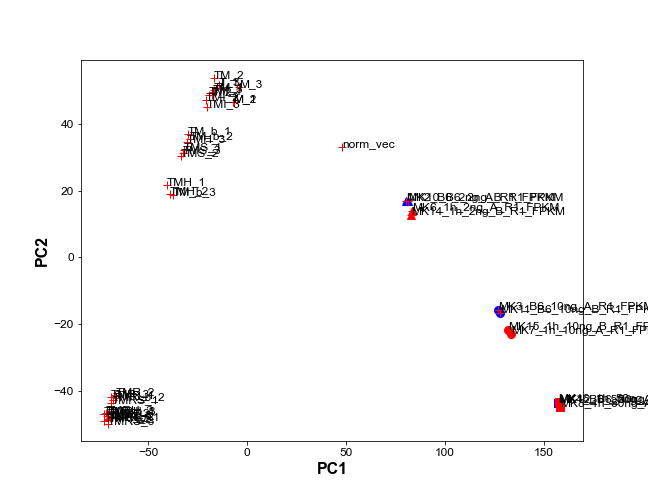

In [175]:
# plotting PCA for shared genes in pert and WTvsMut datasets

fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)



ax.plot(PCA_total_dataset_com.filter(regex='B6_2ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='B6_2ng',axis=0).iloc[:,1],'^',color='blue',label='WT, 2 ng TNF',ms=8) 
ax.plot(PCA_total_dataset_com.filter(regex='B6_10ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='B6_10ng',axis=0).iloc[:,1],'o',color='blue',label='WT, 10 ng TNF',ms=8) 
ax.plot(PCA_total_dataset_com.filter(regex='B6_50ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='B6_50ng',axis=0).iloc[:,1],'s',color='blue',label='WT, 50 ng TNF',ms=8) 

ax.plot(PCA_total_dataset_com.filter(regex='1h_2ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='1h_2ng',axis=0).iloc[:,1],'^',color='red',label='mut, 2 ng TNF',ms=8) 
ax.plot(PCA_total_dataset_com.filter(regex='1h_10ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='1h_10ng',axis=0).iloc[:,1],'o',color='red',label='mut, 10 ng TNF',ms=8) 
ax.plot(PCA_total_dataset_com.filter(regex='1h_50ng',axis=0).iloc[:,0],PCA_total_dataset_com.filter(regex='1h_50ng',axis=0).iloc[:,1],'s',color='red',label='mut, 50 ng TNF',ms=8) 


ax.plot(PCA_total_dataset_com.iloc[:,0],PCA_total_dataset_com.iloc[:,1],'+',color='red',ms=8) 



ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)


for smpl in PCA_total_dataset_com.index:
    ax.annotate(smpl,(PCA_total_dataset_com.loc[smpl][0],PCA_total_dataset_com.loc[smpl][1]))


#ax.legend(numpoints=1,prop=fontLabel)
plt.show()